   # Muon decay experiment

We use this code to:
* simulate the muon decay experiment,
* obtain a best fit value, and 
* the corresponding error for its lifetime.

In [1]:
%matplotlib inline

from __future__ import division    #for division operator
import numpy as np
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import chi2
import time
import matplotlib.pylab as plt
outfilepath = '/Users/Jatan/Google Drive/PHYS2010/Muon_decay/'   #modify this path to your plot directory

We first simulate the muon data set using Monte carlo methods. Initializing...

In [2]:
sig_samples = 1500
bkg_samples = 300
start_t = 0
stop_t = 20 #micro seconds
bw = 0.01 #10 ns
data_bins = np.arange(0, stop_t + bw, bw)
tau = 2.2 # microseconds

## Method 1: Rejection sampling

1800 samples are generated using rejection sampling. Also shown is a scatter plot of events/10ns for reference. 

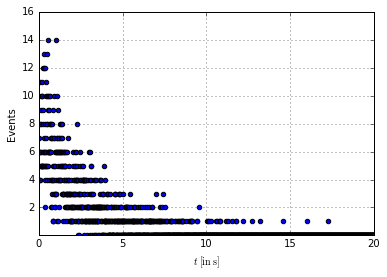

In [15]:
signal = []
count = 1
count_tot = 1
def test_func(arg):
	return (1500*np.exp(-arg/tau) + 0.3)

while count <= (sig_samples+bkg_samples):
	count_tot += 1
	x = stop_t*np.random.random()
	y = 1501*np.random.random()
	if y <= test_func(x):
		signal.append(x)
		count += 1

events, bins = np.histogram(signal, data_bins) #do it for 10 bins?
rescaled_bins = (bins[:-1] + bins[1:]) / 2  #rescaling bins to find midpoints for each bin

fig, ax = plt.subplots(1, 1)
plt.scatter(rescaled_bins, events)
plt.xlim(0, 20)
plt.xlabel(r'$t \; [ \mathrm{in \; s} ]$')
plt.ylim(0, 16)
plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.ylabel(r'Events')
plt.grid()
plt.show()

To avoid binning errors, we perform an unbinned maximum likelihood fit on the data. Since the signal for the muon decay is given by:
\begin{equation}
N(t) = N_\text{sig} \, e^{\frac{-t}{\tau}} + N_\text{bkg}
\end{equation}

it's preferable to use an exponential pdf for the fit. The normalized pdf we consider is
\begin{equation}
f(x) = A\,e^{\frac{-t}{\tau}}
\end{equation}
where
\begin{equation}
A = \frac{1}{\tau\,(1 - e^{\frac{-20}{\tau}})}
\end{equation}

We can define the likelihood function as
\begin{equation}
\mathcal{L}\,(\tau \,|\, t_i) = \prod_{i=1}^{i=N} A \, e^{\frac{-t_i}{\tau}}
\end{equation}

Or equivalently the log likelihood,
\begin{equation}
\log \, \mathcal{L}\,(\tau \,|\, t_i) = \sum_{i=1}^{i=N} \left(\log\,(A) + \,\frac{-t_i}{\tau} \right)
\end{equation}

We maximize the log likelihood to obtain the best fit lifetime $\tau$ and the maximum likelihood value.

In [22]:
def likelihood_fit(params):
	lifetime = params
	logll = np.sum(np.log(1/(lifetime*(1-np.exp(-stop_t/lifetime)))) - (signal/lifetime))
	return -logll

init_params = [1,]
result = minimize(likelihood_fit, init_params, method='nelder-mead')
tau_fit = result.x[0]   #best fit estimator = np.sum(signal)/len(signal)

print likelihood_fit(tau_fit), tau_fit

3213.60292564 2.19560546875


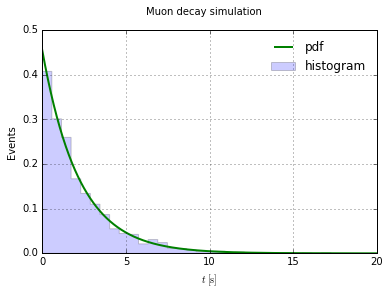

In [26]:
def exp_func(t):
 	A = 1/(tau_fit*(1-np.exp(-stop_t/tau_fit))) #use histogram for accuracy?
 	return A*np.exp(-t/tau_fit) 

fig, ax = plt.subplots(1, 1)
plt.hist(signal, 30, normed='True', histtype='stepfilled', color='blue', alpha=0.2, label='histogram')
plt.plot(data_bins, exp_func(data_bins), color='g', lw='2', label='pdf')
plt.xlim(0, 20)
plt.xlabel(r'$t \; [ \mathrm{s} ]$')
#plt.ylim(0, 300)
#plt.setp(ax.get_yticklabels()[0], visible=False)    
plt.ylabel(r'Events')
plt.suptitle('Muon decay simulation')
plt.legend(loc='upper right', frameon=False)
plt.grid()
plt.show()
#plt.savefig(outfilepath + 'rejection_sampling_1500.pdf')

10^5 MCs for error in lifetime

## Method 2: Inverse cdf method (for signal) + flat bkg

(likelihood fit on binned data with bkg doesn't make sense with exponential pdf, but may work with poission pmf.)

In [39]:
signal = []
for i in range(sig_samples):
	signal.append(-tau*np.log(np.exp(-stop_t/tau) + (1 - np.exp(-stop_t/tau))* np.random.random()))

events, bins = np.histogram(signal, data_bins) #do it for 10 bins?
tot_events = [events[i]+(bkg_samples/(len(bins)-1)) for i in range(len(bins)-1)]
rescaled_bins = (bins[:-1] + bins[1:]) / 2  #rescaling bins to find midpoints for each bin

As there is data available in every bin, we can minimize the chi-squared to obtain best fit parameters ($\,A, \tau$ and $B\,$) for the function,
\begin{equation}
f_\text{fit}(x) = A\,e^{\frac{-t}{\tau}} \, + \, B
\end{equation}

In [37]:
init_params_chisq = [1, 1, 1]
sigma = [np.sqrt(tot_events[i]) for i in range(len(tot_events))]
def func_chisq(arg, A, lifetime, B):
	return (A*np.exp(-arg/lifetime) + B)
chi_sq = curve_fit(func_chisq, rescaled_bins, tot_events, init_params_chisq, sigma)[0]
print chi_sq

2001
